In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ddi-dataset/Neuron_input.csv


In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers

# Load the drug-drug interaction dataset from a CSV file
drug_interaction_data = pd.read_csv("/kaggle/input/ddi-dataset/Neuron_input.csv")

# Display the first few rows of the dataset
print(drug_interaction_data.head())

# Replace the target value 86 with 0 (assuming it's a classification task)
drug_interaction_data['Target'] = drug_interaction_data['Target'].replace(86, 0)

# Prepare features (X) and target (y)
features = drug_interaction_data.drop(['Drug1_ID', 'Drug1', 'Drug2_ID', 'Drug2', 'Target'], axis=1)
X = np.array(features)
y = drug_interaction_data['Target']

# Normalize the features
X = tf.keras.utils.normalize(X, axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Build a neural network model
model = keras.models.Sequential([
    layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='tanh'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

# Function to build a hyperparameter tuning model using Keras Tuner
def build_tuning_model(hp):
    tuning_model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        tuning_model.add(layers.Dense(
            units=hp.Int('units_' + str(i), min_value=16, max_value=256, step=16),
            activation=hp.Choice('activation_' + str(i), ['relu', 'tanh'])
        ))
        tuning_model.add(layers.Dropout(0.3))
    tuning_model.add(layers.Dense(1, activation='sigmoid'))
    tuning_model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return tuning_model

# Create a RandomSearch tuner for hyperparameter tuning
tuner = RandomSearch(
    build_tuning_model,
    objective='val_accuracy',
    max_trials=5,
    directory='Drug_Drug_Interaction',
    project_name='DDI_Tuning'
)

# Display the search space summary
tuner.search_space_summary()

# Perform hyperparameter tuning search
tuner.search(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=32
)

# Display results summary
tuner.results_summary()

# Save the best trained model to a file
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save("best_ddi_model.h5")


Epoch 1/100
4016/4016 [==============================] - 23s 5ms/step - loss: 1.7158 - accuracy: 0.5009 - val_loss: 1.2860 - val_accuracy: 0.6112
Epoch 2/100
4016/4016 [==============================] - 20s 5ms/step - loss: 1.1689 - accuracy: 0.6464 - val_loss: 1.0225 - val_accuracy: 0.6827
Epoch 3/100
4016/4016 [==============================] - 20s 5ms/step - loss: 0.9724 - accuracy: 0.7035 - val_loss: 0.8927 - val_accuracy: 0.7237
Epoch 4/100
4016/4016 [==============================] - 20s 5ms/step - loss: 0.8519 - accuracy: 0.7381 - val_loss: 0.8148 - val_accuracy: 0.7454
Epoch 5/100
4016/4016 [==============================] - 21s 5ms/step - loss: 0.7690 - accuracy: 0.7613 - val_loss: 0.7222 - val_accuracy: 0.7722
Epoch 6/100
4016/4016 [==============================] - 20s 5ms/step - loss: 0.7126 - accuracy: 0.7777 - val_loss: 0.6841 - val_accuracy: 0.7837
Epoch 7/100
4016/4016 [==============================] - 19s 5ms/step - loss: 0.6658 - accuracy: 0.7911 - val_loss: 0.6578 -

In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

# Load your dataset
data_dir = 'DDI'

df = pd.read_csv(os.path.join(data_dir, '/kaggle/input/ddi-dataset/Neuron_input.csv'))

X = df.drop(['Drug1_ID', 'Drug1', 'Drug2_ID', 'Drug2', 'Y'], axis=1)
y = df.Y

y = y.replace(86, 0)

# Initialize lists to store results
acc_cv_scores = []
auc_cv_scores = []

# Create a label binarizer for multi-class ROC AUC calculation
lb = LabelBinarizer()

kfold = StratifiedKFold(n_splits=5, shuffle=True)

for train, test in kfold.split(X, y):
    # Train your classifier (RandomForestClassifier) on the training data
    svm_model = RandomForestClassifier()
    svm_model.fit(X.iloc[train], y[train])
    
    # Evaluate the model on the test data
    true_labels = y[test]
    predicted_labels = svm_model.predict(X.iloc[test])
    
    # Calculate accuracy
    acc = accuracy_score(true_labels, predicted_labels)
    acc_cv_scores.append(acc)
    
    # Convert true labels and predicted labels to binary format for ROC AUC
    true_labels_bin = lb.fit_transform(true_labels)
    predicted_labels_bin = lb.transform(predicted_labels)
    
    # Calculate ROC AUC (average='macro' for multi-class)
    auc = roc_auc_score(true_labels_bin, predicted_labels_bin, average='macro')
    auc_cv_scores.append(auc)

print('Accuracy = ', np.mean(acc_cv_scores))
print('AUC = ', np.mean(auc_cv_scores))


import joblib

# Train your RandomForestClassifier on the entire dataset (or a specific split)
svm_model = RandomForestClassifier()
svm_model.fit(X, y)

# Save the trained model to a file using joblib
model_filename = "random_forest_model.joblib"
joblib.dump(svm_model, model_filename)


Accuracy =  0.8813657203354834
AUC =  0.8405368907969022


['random_forest_model.joblib']

In [21]:
!pip install rdkit-pypi
!pip install numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 36.7 MB/s eta 0:00:0000:0100:01


In [4]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 31.8 MB/s eta 0:00:0000:0100:01


In [21]:
! pip install pubchempy

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=495c83ce5277b30b415de47766f88cbf6bdcd1951f02eda4f11a2631dae795a5
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [19]:
import numpy as np
from tensorflow import keras
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

# Define a function to compute the Tanimoto similarity between two molecules
def compute_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return 0.0  # Handle invalid input

    fp1 = FingerprintMols.FingerprintMol(mol1)
    fp2 = FingerprintMols.FingerprintMol(mol2)
    
    return DataStructs.TanimotoSimilarity(fp1, fp2)

# Example drug SMILES notations
drug1_smiles = r'CN(C)CCOC(C)(C1=CC=CC=C1)C1=CC=CC=N1'
drug2_smiles = r'CC(N)CC1=CC=CC=C1'

# Compute the structural similarity score between the drug pair
similarity_score = compute_similarity(drug1_smiles, drug2_smiles)

# Create an SSP feature vector (100 components as per your description)
ssp_feature_vector = np.array([similarity_score] * 100)

# Load the saved model
loaded_model = keras.models.load_model("/kaggle/input/ddi-model/ddi_model.h5")

# Prepare input data for prediction (reshape the feature vector)
input_data = ssp_feature_vector.reshape(1, -1)

# Make predictions using the loaded model
predictions = loaded_model.predict(input_data)

# Find the class label with the highest probability
predicted_class = np.argmax(predictions)

# Output the predicted class label
print("Predicted Class Label:", predicted_class)

# Dictionary mapping predicted class labels to descriptions
class_description_mapping = {
    1: "Drug1 can cause an increase in the absorption of Drug2 resulting in an increased serum concentration and potentially a worsening of adverse effects.",
    2: "Drug1 can cause a decrease in the absorption of Drug2 resulting in a reduced serum concentration and potentially a decrease in efficacy.",
    3: "The risk or severity of adverse effects can be increased when Drug1 is combined with Drug2.",
    4: "The bioavailability of Drug2 can be decreased when combined with Drug1.",
    5: "Drug1 may decrease the vasoconstricting activities of Drug2.",
    6: "Drug1 may increase the anticoagulant activities of Drug2.",
    7: "Drug1 may increase the ototoxic activities of Drug2.",
    8: "The therapeutic efficacy of Drug2 can be increased when used in combination with Drug1.",
    9: "The serum concentration of Drug2 can be decreased when it is combined with Drug1.",
    10: "The risk or severity of hypertension can be increased when Drug2 is combined with Drug1.",
    11: "The serum concentration of the active metabolites of Drug2 can be reduced when Drug2 is used in combination with Drug1 resulting in a loss in efficacy.",
    12: "Drug1 may decrease the anticoagulant activities of Drug2.",
    13: "The absorption of Drug2 can be decreased when combined with Drug1.",
    14: "Drug1 may decrease the bronchodilatory activities of Drug2.",
    15: "Drug1 may decrease the bioavailability of Drug2.",
    16: "Drug1 may increase the central neurotoxic activities of Drug2.",
    17: "Drug1 may increase the cardiotoxic activities of Drug2.",
    18: "Drug1 may increase the cardiotoxic activities of Drug2.",
    19: "Drug1 may increase the vasoconstricting activities of Drug2.",
    20: "Drug1 may increase the QTc-prolonging activities of Drug2.",
    21: "Drug1 may increase the neuromuscular blocking activities of Drug2.",
    22: "Drug1 may increase the adverse neuromuscular activities of Drug2.",
    23: "Drug1 may increase the stimulatory activities of Drug2.",
    24: "Drug1 may decrease effectiveness of Drug2 as a diagnostic agent.",
    25: "Drug1 may increase the atrioventricular blocking (AV block) activities of Drug2.",
    26: "Drug1 may decrease the antiplatelet activities of Drug2.",
    27: "Drug1 may increase the neuroexcitatory activities of Drug2.",
    28: "Drug1 may increase the dermatologic adverse activities of Drug2.",
    29: "Drug1 may decrease the diuretic activities of Drug2.",
    30: "Drug1 may increase the orthostatic hypotensive activities of Drug2.",
    31: "The risk or severity of hypertension can be increased when Drug1 is combined with Drug2.",
    32: "The risk or severity of QTc prolongation can be increased when Drug1 is combined with Drug2.",
    33: "Drug1 may decrease the analgesic activities of Drug2.",
    34: "Drug1 may decrease the anticoagulant activities of Drug2.",
    35: "Drug1 may decrease the antihypertensive activities of Drug2.",
    36: "Drug1 may decrease the antiplatelet activities of Drug2.",
    37: "Drug1 may decrease the antihypertensive activities of Drug2.",
    38: "Drug1 may increase the vasodilatory activities of Drug2.",
    39: "Drug1 may increase the constipating activities of Drug2.",
    40: "Drug1 may increase the respiratory depressant activities of Drug2.",
    41: "Drug1 may increase the hypotensive and central nervous system depressant (CNS depressant) activities of Drug2.",
    42: "The risk or severity of hyperkalemia can be increased when Drug1 is combined with Drug2.",
    43: "The protein binding of Drug2 can be decreased when combined with Drug1.",
    44: "Drug1 may increase the central nervous system depressant (CNS depressant) and hypertensive activities of Drug2.",
    45: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
    46: "Drug1 may increase the bronchoconstrictory activities of Drug2.",
    47: "The metabolism of Drug2 can be decreased when combined with Drug1.",
    48: "Drug1 may increase the myopathic rhabdomyolysis activities of Drug2.",
    49: "The risk or severity of adverse effects can be increased when Drug1 is combined with Drug2.",
    50: "The risk or severity of heart failure can be increased when Drug2 is combined with Drug1.",
    51: "Drug1 may increase the hypercalcemic activities of Drug2.",
    52: "Drug1 may decrease the analgesic activities of Drug2.",
    53: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
    54: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
    55: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
    56: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
    57: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
    58: "Drug1 may decrease the cardiotoxic activities of Drug2.",
    59: "Drug1 may increase the ulcerogenic activities of Drug2.",
    60: "Drug1 may increase the hyponatremic activities of Drug2.",
    61: "Drug1 may decrease the sedative activities of Drug2.",
    62: "Drug1 may decrease the excretion rate of Drug2 which could result in a higher serum level.",
    63: "Drug1 may increase the myelosuppressive activities of Drug2.",
    64: "Drug1 may increase the hypoglycemic activities of Drug2.",
    65: "Drug1 may increase the excretion rate of Drug2 which could result in a lower serum level and potentially a reduction in efficacy.",
    66: "The risk or severity of bleeding can be increased when Drug1 is combined with Drug2.",
    67: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
    68: "Drug1 may increase the analgesic activities of Drug2.",
    69: "Drug1 may increase the analgesic activities of Drug2.",
    70: "The therapeutic efficacy of Drug2 can be decreased when used in combination with Drug1.",
    71: "Drug1 may increase the hypertensive activities of Drug2.",
    72: "Drug1 may decrease the excretion rate of Drug2 which could result in a higher serum level.",
    73: "The serum concentration of Drug2 can be increased when it is combined with Drug1.",
    74: "Drug1 may increase the fluid retaining activities of Drug2.",
    75: "The serum concentration of Drug2 can be decreased when it is combined with Drug1.",
    76: "Drug1 may decrease the sedative activities of Drug2.",
    77: "The serum concentration of the active metabolites of Drug2 can be increased when Drug2 is used in combination with Drug1.",
    78: "Drug1 may increase the hyperglycemic activities of Drug2.",
    79: "Drug1 may increase the central nervous system depressant (CNS depressant) and hypertensive activities of Drug2.",
    80: "Drug1 may increase the hepatotoxic activities of Drug2.",
    81: "Drug1 may increase the thrombogenic activities of Drug2.",
    82: "Drug1 may increase the arrhythmogenic activities of Drug2.",
    83: "Drug1 may increase the vasopressor activities of Drug2.",
    84: "Drug1 may increase the vasodilatory activities of Drug2.",
    85: "Drug1 may increase the tachycardic activities of Drug2.",
    86: "The risk of a hypersensitivity reaction to Drug2 is increased when it is combined with Drug1."
}

# Check if the predicted class label exists in the mapping dictionary
if predicted_class in class_description_mapping:
    description = class_description_mapping[predicted_class]
    print("Predicted Class Label:", predicted_class)
    print("Description:", description)
else:
    print("Predicted Class Label not found in the mapping.")

# Output will display the predicted class label and its description


1/1 [==============================] - 0s 76ms/step
Predicted Class Label: 60
Predicted Class Label: 60
Description: Drug1 may increase the hyponatremic activities of Drug2.


In [13]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/random_forest_model.joblib (deflated 97%)
  adding: kaggle/working/ddi_model.h5 (deflated 13%)
  adding: kaggle/working/Drug_Drug_Interaction/ (stored 0%)
  adding: kaggle/working/Drug_Drug_Interaction/DDI_Tuning/ (stored 0%)
  adding: kaggle/working/Drug_Drug_Interaction/DDI_Tuning/trial_4/ (stored 0%)
  adding: kaggle/working/Drug_Drug_Interaction/DDI_Tuning/trial_4/trial.json (deflated 92%)
  adding: kaggle/working/Drug_Drug_Interaction/DDI_Tuning/trial_4/checkpoint (deflated 48%)
  adding: kaggle/working/Drug_Drug_Interaction/DDI_Tuning/trial_4/checkpoint.index (deflated 70%)
  adding: kaggle/working/Drug_Drug_Interaction/DDI_Tuning/trial_4/checkpoint.data-00000-of-00001 (deflated 25%)
  adding: kaggle/working/Drug_Drug_Interaction/DDI_Tuning/trial_0/ (stored 0%)
  adding: kaggle/working/Drug_Drug_Interaction/DDI_Tuning/trial_0/trial.json (deflated 92%)
  adding: 

In [14]:
!ls

Drug_Drug_Interaction  ddi_model.h5  file.zip  random_forest_model.joblib


In [15]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [22]:
import numpy as np
from tensorflow import keras
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import pubchempy as pcp

# Define a function to compute the Tanimoto similarity between two molecules
def compute_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return 0.0  # Handle invalid input

    fp1 = FingerprintMols.FingerprintMol(mol1)
    fp2 = FingerprintMols.FingerprintMol(mol2)
    
    return DataStructs.TanimotoSimilarity(fp1, fp2)

# Define a function to get SMILES notation for a drug name
def get_smiles_for_drug(drug_name):
    try:
        # Search PubChem for the drug by name
        compounds = pcp.get_compounds(drug_name, 'name')
        
        if compounds:
            # Take the first result (you may want to handle multiple results differently)
            compound = compounds[0]
            
            # Check if SMILES notation is available
            if compound.isomeric_smiles:
                return compound.isomeric_smiles
            else:
                return "SMILES notation not found for this drug."
        else:
            return "Drug not found in PubChem database."
    
    except Exception as e:
        return str(e)

# Function to predict DDI for a pair of drugs
def predict_ddi_for_drugs(drug1_name, drug2_name, model_path):
    # Get SMILES notations for the drugs
    drug1_smiles = get_smiles_for_drug(drug1_name)
    drug2_smiles = get_smiles_for_drug(drug2_name)
    
    if "SMILES notation not found" in (drug1_smiles, drug2_smiles):
        return "SMILES notation not found for one or both drugs."
    
    # Compute the structural similarity score between the drug pair
    similarity_score = compute_similarity(drug1_smiles, drug2_smiles)

    # Create an SSP feature vector (100 components as per your description)
    ssp_feature_vector = np.array([similarity_score] * 100)

    # Load the saved model
    loaded_model = keras.models.load_model(model_path)

    # Prepare input data for prediction (reshape the feature vector)
    input_data = ssp_feature_vector.reshape(1, -1)

    # Make predictions using the loaded model
    predictions = loaded_model.predict(input_data)

    # Find the class label with the highest probability
    predicted_class = np.argmax(predictions)

    # Dictionary mapping predicted class labels to descriptions
    class_description_mapping = {
        1: "Drug1 can cause an increase in the absorption of Drug2 resulting in an increased serum concentration and potentially a worsening of adverse effects.",
        2: "Drug1 can cause a decrease in the absorption of Drug2 resulting in a reduced serum concentration and potentially a decrease in efficacy.",
        3: "The risk or severity of adverse effects can be increased when Drug1 is combined with Drug2.",
        4: "The bioavailability of Drug2 can be decreased when combined with Drug1.",
        5: "Drug1 may decrease the vasoconstricting activities of Drug2.",
        6: "Drug1 may increase the anticoagulant activities of Drug2.",
        7: "Drug1 may increase the ototoxic activities of Drug2.",
        8: "The therapeutic efficacy of Drug2 can be increased when used in combination with Drug1.",
        9: "The serum concentration of Drug2 can be decreased when it is combined with Drug1.",
        10: "The risk or severity of hypertension can be increased when Drug2 is combined with Drug1.",
        11: "The serum concentration of the active metabolites of Drug2 can be reduced when Drug2 is used in combination with Drug1 resulting in a loss in efficacy.",
        12: "Drug1 may decrease the anticoagulant activities of Drug2.",
        13: "The absorption of Drug2 can be decreased when combined with Drug1.",
        14: "Drug1 may decrease the bronchodilatory activities of Drug2.",
        15: "Drug1 may decrease the bioavailability of Drug2.",
        16: "Drug1 may increase the central neurotoxic activities of Drug2.",
        17: "Drug1 may increase the cardiotoxic activities of Drug2.",
        18: "Drug1 may increase the cardiotoxic activities of Drug2.",
        19: "Drug1 may increase the vasoconstricting activities of Drug2.",
        20: "Drug1 may increase the QTc-prolonging activities of Drug2.",
        21: "Drug1 may increase the neuromuscular blocking activities of Drug2.",
        22: "Drug1 may increase the adverse neuromuscular activities of Drug2.",
        23: "Drug1 may increase the stimulatory activities of Drug2.",
        24: "Drug1 may decrease effectiveness of Drug2 as a diagnostic agent.",
        25: "Drug1 may increase the atrioventricular blocking (AV block) activities of Drug2.",
        26: "Drug1 may decrease the antiplatelet activities of Drug2.",
        27: "Drug1 may increase the neuroexcitatory activities of Drug2.",
        28: "Drug1 may increase the dermatologic adverse activities of Drug2.",
        29: "Drug1 may decrease the diuretic activities of Drug2.",
        30: "Drug1 may increase the orthostatic hypotensive activities of Drug2.",
        31: "The risk or severity of hypertension can be increased when Drug1 is combined with Drug2.",
        32: "The risk or severity of QTc prolongation can be increased when Drug1 is combined with Drug2.",
        33: "Drug1 may decrease the analgesic activities of Drug2.",
        34: "Drug1 may decrease the anticoagulant activities of Drug2.",
        35: "Drug1 may decrease the antihypertensive activities of Drug2.",
        36: "Drug1 may decrease the antiplatelet activities of Drug2.",
        37: "Drug1 may decrease the antihypertensive activities of Drug2.",
        38: "Drug1 may increase the vasodilatory activities of Drug2.",
        39: "Drug1 may increase the constipating activities of Drug2.",
        40: "Drug1 may increase the respiratory depressant activities of Drug2.",
        41: "Drug1 may increase the hypotensive and central nervous system depressant (CNS depressant) activities of Drug2.",
        42: "The risk or severity of hyperkalemia can be increased when Drug1 is combined with Drug2.",
        43: "The protein binding of Drug2 can be decreased when combined with Drug1.",
        44: "Drug1 may increase the central nervous system depressant (CNS depressant) and hypertensive activities of Drug2.",
        45: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        46: "Drug1 may increase the bronchoconstrictory activities of Drug2.",
        47: "The metabolism of Drug2 can be decreased when combined with Drug1.",
        48: "Drug1 may increase the myopathic rhabdomyolysis activities of Drug2.",
        49: "The risk or severity of adverse effects can be increased when Drug1 is combined with Drug2.",
        50: "The risk or severity of heart failure can be increased when Drug2 is combined with Drug1.",
        51: "Drug1 may increase the hypercalcemic activities of Drug2.",
        52: "Drug1 may decrease the analgesic activities of Drug2.",
        53: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        54: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        55: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        56: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
        57: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
        58: "Drug1 may decrease the cardiotoxic activities of Drug2.",
        59: "Drug1 may increase the ulcerogenic activities of Drug2.",
        60: "Drug1 may increase the hyponatremic activities of Drug2.",
        61: "Drug1 may decrease the sedative activities of Drug2.",
        62: "Drug1 may decrease the excretion rate of Drug2 which could result in a higher serum level.",
        63: "Drug1 may increase the myelosuppressive activities of Drug2.",
        64: "Drug1 may increase the hypoglycemic activities of Drug2.",
        65: "Drug1 may increase the excretion rate of Drug2 which could result in a lower serum level and potentially a reduction in efficacy.",
        66: "The risk or severity of bleeding can be increased when Drug1 is combined with Drug2.",
        67: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
        68: "Drug1 may increase the analgesic activities of Drug2.",
        69: "Drug1 may increase the analgesic activities of Drug2.",
        70: "The therapeutic efficacy of Drug2 can be decreased when used in combination with Drug1.",
        71: "Drug1 may increase the hypertensive activities of Drug2.",
        72: "Drug1 may decrease the excretion rate of Drug2 which could result in a higher serum level.",
        73: "The serum concentration of Drug2 can be increased when it is combined with Drug1.",
        74: "Drug1 may increase the fluid retaining activities of Drug2.",
        75: "The serum concentration of Drug2 can be decreased when it is combined with Drug1.",
        76: "Drug1 may decrease the sedative activities of Drug2.",
        77: "The serum concentration of the active metabolites of Drug2 can be increased when Drug2 is used in combination with Drug1.",
        78: "Drug1 may increase the hyperglycemic activities of Drug2.",
        79: "Drug1 may increase the central nervous system depressant (CNS depressant) and hypertensive activities of Drug2.",
        80: "Drug1 may increase the hepatotoxic activities of Drug2.",
        81: "Drug1 may increase the thrombogenic activities of Drug2.",
        82: "Drug1 may increase the arrhythmogenic activities of Drug2.",
        83: "Drug1 may increase the vasopressor activities of Drug2.",
        84: "Drug1 may increase the vasodilatory activities of Drug2.",
        85: "Drug1 may increase the tachycardic activities of Drug2.",
        86: "The risk of a hypersensitivity reaction to Drug2 is increased when it is combined with Drug1."
    }

    # Check if the predicted class label exists in the mapping dictionary
    if predicted_class in class_description_mapping:
        description = class_description_mapping[predicted_class]
    else:
        description = "Predicted Class Label not found in the mapping."

    return f"Predicted Class Label: {predicted_class}\nDescription: {description}"

# Example drug names
drug1_name = "Aspirin"
drug2_name = "Ibuprofen"

# Path to the saved model
model_path = "/kaggle/input/ddi-model/ddi_model.h5"

# Make predictions for Drug-Drug Interaction
result = predict_ddi_for_drugs(drug1_name, drug2_name, model_path)

# Output the result
print(result)


1/1 [==============================] - 0s 128ms/step
Predicted Class Label: 60
Description: Drug1 may increase the hyponatremic activities of Drug2.


1/1 [==============================] - 0s 75ms/step
Drug 1: Aspirin (SMILES: CC(=O)OC1=CC=CC=C1C(=O)O, Molecular Formula: C9H8O4)
Drug 2: Ibuprofen (SMILES: CC(C)CC1=CC=C(C=C1)C(C)C(=O)O, Molecular Formula: C13H18O2)
Predicted Class Label: 60
Description: Drug1 may increase the hyponatremic activities of Drug2.


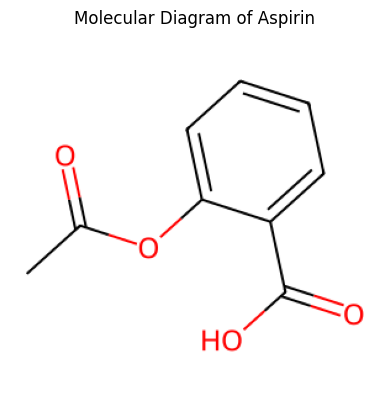

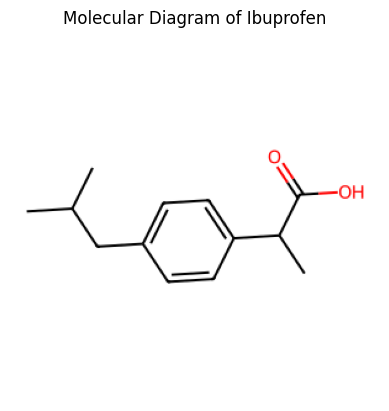

In [25]:
import numpy as np
from tensorflow import keras
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Draw
import pubchempy as pcp
import matplotlib.pyplot as plt

# Define a function to compute the Tanimoto similarity between two molecules
def compute_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return 0.0  # Handle invalid input

    fp1 = FingerprintMols.FingerprintMol(mol1)
    fp2 = FingerprintMols.FingerprintMol(mol2)
    
    return DataStructs.TanimotoSimilarity(fp1, fp2)

# Define a function to get SMILES notation for a drug name
def get_smiles_for_drug(drug_name):
    try:
        # Search PubChem for the drug by name
        compounds = pcp.get_compounds(drug_name, 'name')
        
        if compounds:
            # Take the first result (you may want to handle multiple results differently)
            compound = compounds[0]
            
            # Check if SMILES notation is available
            if compound.isomeric_smiles:
                return compound.isomeric_smiles, compound.molecular_formula
            else:
                return "SMILES notation not found for this drug.", None
        else:
            return "Drug not found in PubChem database.", None
    
    except Exception as e:
        return str(e), None

# Function to predict DDI for a pair of drugs
def predict_ddi_for_drugs(drug1_name, drug2_name, model_path):
    # Get SMILES notations and molecular formulas for the drugs
    drug1_smiles, drug1_formula = get_smiles_for_drug(drug1_name)
    drug2_smiles, drug2_formula = get_smiles_for_drug(drug2_name)
    
    if "SMILES notation not found" in (drug1_smiles, drug2_smiles):
        return "SMILES notation not found for one or both drugs.", None, None
    
    # Compute the structural similarity score between the drug pair
    similarity_score = compute_similarity(drug1_smiles, drug2_smiles)

    # Create an SSP feature vector (100 components as per your description)
    ssp_feature_vector = np.array([similarity_score] * 100)

    # Load the saved model
    loaded_model = keras.models.load_model(model_path)

    # Prepare input data for prediction (reshape the feature vector)
    input_data = ssp_feature_vector.reshape(1, -1)

    # Make predictions using the loaded model
    predictions = loaded_model.predict(input_data)

    # Find the class label with the highest probability
    predicted_class = np.argmax(predictions)

    # Dictionary mapping predicted class labels to descriptions
    class_description_mapping = {
        1: "Drug1 can cause an increase in the absorption of Drug2 resulting in an increased serum concentration and potentially a worsening of adverse effects.",
        2: "Drug1 can cause a decrease in the absorption of Drug2 resulting in a reduced serum concentration and potentially a decrease in efficacy.",
        3: "The risk or severity of adverse effects can be increased when Drug1 is combined with Drug2.",
        4: "The bioavailability of Drug2 can be decreased when combined with Drug1.",
        5: "Drug1 may decrease the vasoconstricting activities of Drug2.",
        6: "Drug1 may increase the anticoagulant activities of Drug2.",
        7: "Drug1 may increase the ototoxic activities of Drug2.",
        8: "The therapeutic efficacy of Drug2 can be increased when used in combination with Drug1.",
        9: "The serum concentration of Drug2 can be decreased when it is combined with Drug1.",
        10: "The risk or severity of hypertension can be increased when Drug2 is combined with Drug1.",
        11: "The serum concentration of the active metabolites of Drug2 can be reduced when Drug2 is used in combination with Drug1 resulting in a loss in efficacy.",
        12: "Drug1 may decrease the anticoagulant activities of Drug2.",
        13: "The absorption of Drug2 can be decreased when combined with Drug1.",
        14: "Drug1 may decrease the bronchodilatory activities of Drug2.",
        15: "Drug1 may decrease the bioavailability of Drug2.",
        16: "Drug1 may increase the central neurotoxic activities of Drug2.",
        17: "Drug1 may increase the cardiotoxic activities of Drug2.",
        18: "Drug1 may increase the cardiotoxic activities of Drug2.",
        19: "Drug1 may increase the vasoconstricting activities of Drug2.",
        20: "Drug1 may increase the QTc-prolonging activities of Drug2.",
        21: "Drug1 may increase the neuromuscular blocking activities of Drug2.",
        22: "Drug1 may increase the adverse neuromuscular activities of Drug2.",
        23: "Drug1 may increase the stimulatory activities of Drug2.",
        24: "Drug1 may decrease effectiveness of Drug2 as a diagnostic agent.",
        25: "Drug1 may increase the atrioventricular blocking (AV block) activities of Drug2.",
        26: "Drug1 may decrease the antiplatelet activities of Drug2.",
        27: "Drug1 may increase the neuroexcitatory activities of Drug2.",
        28: "Drug1 may increase the dermatologic adverse activities of Drug2.",
        29: "Drug1 may decrease the diuretic activities of Drug2.",
        30: "Drug1 may increase the orthostatic hypotensive activities of Drug2.",
        31: "The risk or severity of hypertension can be increased when Drug1 is combined with Drug2.",
        32: "The risk or severity of QTc prolongation can be increased when Drug1 is combined with Drug2.",
        33: "Drug1 may decrease the analgesic activities of Drug2.",
        34: "Drug1 may decrease the anticoagulant activities of Drug2.",
        35: "Drug1 may decrease the antihypertensive activities of Drug2.",
        36: "Drug1 may decrease the antiplatelet activities of Drug2.",
        37: "Drug1 may decrease the antihypertensive activities of Drug2.",
        38: "Drug1 may increase the vasodilatory activities of Drug2.",
        39: "Drug1 may increase the constipating activities of Drug2.",
        40: "Drug1 may increase the respiratory depressant activities of Drug2.",
        41: "Drug1 may increase the hypotensive and central nervous system depressant (CNS depressant) activities of Drug2.",
        42: "The risk or severity of hyperkalemia can be increased when Drug1 is combined with Drug2.",
        43: "The protein binding of Drug2 can be decreased when combined with Drug1.",
        44: "Drug1 may increase the central nervous system depressant (CNS depressant) and hypertensive activities of Drug2.",
        45: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        46: "Drug1 may increase the bronchoconstrictory activities of Drug2.",
        47: "The metabolism of Drug2 can be decreased when combined with Drug1.",
        48: "Drug1 may increase the myopathic rhabdomyolysis activities of Drug2.",
        49: "The risk or severity of adverse effects can be increased when Drug1 is combined with Drug2.",
        50: "The risk or severity of heart failure can be increased when Drug2 is combined with Drug1.",
        51: "Drug1 may increase the hypercalcemic activities of Drug2.",
        52: "Drug1 may decrease the analgesic activities of Drug2.",
        53: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        54: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        55: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        56: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
        57: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
        58: "Drug1 may decrease the cardiotoxic activities of Drug2.",
        59: "Drug1 may increase the ulcerogenic activities of Drug2.",
        60: "Drug1 may increase the hyponatremic activities of Drug2.",
        61: "Drug1 may decrease the sedative activities of Drug2.",
        62: "Drug1 may decrease the excretion rate of Drug2 which could result in a higher serum level.",
        63: "Drug1 may increase the myelosuppressive activities of Drug2.",
        64: "Drug1 may increase the hypoglycemic activities of Drug2.",
        65: "Drug1 may increase the excretion rate of Drug2 which could result in a lower serum level and potentially a reduction in efficacy.",
        66: "The risk or severity of bleeding can be increased when Drug1 is combined with Drug2.",
        67: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
        68: "Drug1 may increase the analgesic activities of Drug2.",
        69: "Drug1 may increase the analgesic activities of Drug2.",
        70: "The therapeutic efficacy of Drug2 can be decreased when used in combination with Drug1.",
        71: "Drug1 may increase the hypertensive activities of Drug2.",
        72: "Drug1 may decrease the excretion rate of Drug2 which could result in a higher serum level.",
        73: "The serum concentration of Drug2 can be increased when it is combined with Drug1.",
        74: "Drug1 may increase the fluid retaining activities of Drug2.",
        75: "The serum concentration of Drug2 can be decreased when it is combined with Drug1.",
        76: "Drug1 may decrease the sedative activities of Drug2.",
        77: "The serum concentration of the active metabolites of Drug2 can be increased when Drug2 is used in combination with Drug1.",
        78: "Drug1 may increase the hyperglycemic activities of Drug2.",
        79: "Drug1 may increase the central nervous system depressant (CNS depressant) and hypertensive activities of Drug2.",
        80: "Drug1 may increase the hepatotoxic activities of Drug2.",
        81: "Drug1 may increase the thrombogenic activities of Drug2.",
        82: "Drug1 may increase the arrhythmogenic activities of Drug2.",
        83: "Drug1 may increase the vasopressor activities of Drug2.",
        84: "Drug1 may increase the vasodilatory activities of Drug2.",
        85: "Drug1 may increase the tachycardic activities of Drug2.",
        86: "The risk of a hypersensitivity reaction to Drug2 is increased when it is combined with Drug1."
    }

    # Check if the predicted class label exists in the mapping dictionary
    if predicted_class in class_description_mapping:
        description = class_description_mapping[predicted_class]
    else:
        description = "Predicted Class Label not found in the mapping."

    # Generate molecular diagrams (if molecular formulas are available)
    drug1_molecule = None
    drug2_molecule = None
    if drug1_smiles:
        drug1_molecule = Chem.MolFromSmiles(drug1_smiles)
    if drug2_smiles:
        drug2_molecule = Chem.MolFromSmiles(drug2_smiles)

    # Save molecular diagrams as images
    drug1_image_path = "drug1_molecule.png"
    drug2_image_path = "drug2_molecule.png"
    if drug1_molecule:
        Draw.MolToImage(drug1_molecule, size=(300, 300)).save(drug1_image_path)
    if drug2_molecule:
        Draw.MolToImage(drug2_molecule, size=(300, 300)).save(drug2_image_path)

    return f"Drug 1: {drug1_name} (SMILES: {drug1_smiles}, Molecular Formula: {drug1_formula})\n" \
           f"Drug 2: {drug2_name} (SMILES: {drug2_smiles}, Molecular Formula: {drug2_formula})\n" \
           f"Predicted Class Label: {predicted_class}\n" \
           f"Description: {description}", drug1_image_path, drug2_image_path

# Example drug names
drug1_name = "Aspirin"
drug2_name = "Ibuprofen"

# Path to the saved model
model_path = "/kaggle/input/ddi-model/ddi_model.h5"

# Make predictions for Drug-Drug Interaction
result, drug1_image_path, drug2_image_path = predict_ddi_for_drugs(drug1_name, drug2_name, model_path)

# Output the result
print(result)

# Display molecular diagrams (if available)
if drug1_image_path:
    drug1_image = plt.imread(drug1_image_path)
    plt.imshow(drug1_image)
    plt.axis('off')
    plt.title(f"Molecular Diagram of {drug1_name}")
    plt.show()

if drug2_image_path:
    drug2_image = plt.imread(drug2_image_path)
    plt.imshow(drug2_image)
    plt.axis('off')
    plt.title(f"Molecular Diagram of {drug2_name}")
    plt.show()


In [28]:
import streamlit as st
import numpy as np
from tensorflow import keras
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Draw
import pubchempy as pcp
import matplotlib.pyplot as plt

# Define a function to compute the Tanimoto similarity between two molecules
def compute_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return 0.0  # Handle invalid input

    fp1 = FingerprintMols.FingerprintMol(mol1)
    fp2 = FingerprintMols.FingerprintMol(mol2)

    return DataStructs.TanimotoSimilarity(fp1, fp2)

# Define a function to get SMILES notation for a drug name
def get_smiles_for_drug(drug_name):
    try:
        # Search PubChem for the drug by name
        compounds = pcp.get_compounds(drug_name, 'name')

        if compounds:
            # Take the first result (you may want to handle multiple results differently)
            compound = compounds[0]

            # Check if SMILES notation is available
            if compound.isomeric_smiles:
                return compound.isomeric_smiles, compound.molecular_formula
            else:
                return "SMILES notation not found for this drug.", None
        else:
            return "Drug not found in PubChem database.", None

    except Exception as e:
        return str(e), None

# Function to predict DDI for a pair of drugs
def predict_ddi_for_drugs(drug1_name, drug2_name, model_path):
    # Get SMILES notations and molecular formulas for the drugs
    drug1_smiles, drug1_formula = get_smiles_for_drug(drug1_name)
    drug2_smiles, drug2_formula = get_smiles_for_drug(drug2_name)

    if "SMILES notation not found" in (drug1_smiles, drug2_smiles):
        return "SMILES notation not found for one or both drugs.", None, None

    # Compute the structural similarity score between the drug pair
    similarity_score = compute_similarity(drug1_smiles, drug2_smiles)

    # Create an SSP feature vector (100 components as per your description)
    ssp_feature_vector = np.array([similarity_score] * 100)

    # Load the saved model
    loaded_model = keras.models.load_model(model_path)

    # Prepare input data for prediction (reshape the feature vector)
    input_data = ssp_feature_vector.reshape(1, -1)

    # Make predictions using the loaded model
    predictions = loaded_model.predict(input_data)

    # Find the class label with the highest probability
    predicted_class = np.argmax(predictions)

    # Dictionary mapping predicted class labels to descriptions
    class_description_mapping = {
        1: "Drug1 can cause an increase in the absorption of Drug2 resulting in an increased serum concentration and potentially a worsening of adverse effects.",
        2: "Drug1 can cause a decrease in the absorption of Drug2 resulting in a reduced serum concentration and potentially a decrease in efficacy.",
        3: "The risk or severity of adverse effects can be increased when Drug1 is combined with Drug2.",
        4: "The bioavailability of Drug2 can be decreased when combined with Drug1.",
        5: "Drug1 may decrease the vasoconstricting activities of Drug2.",
        6: "Drug1 may increase the anticoagulant activities of Drug2.",
        7: "Drug1 may increase the ototoxic activities of Drug2.",
        8: "The therapeutic efficacy of Drug2 can be increased when used in combination with Drug1.",
        9: "The serum concentration of Drug2 can be decreased when it is combined with Drug1.",
        10: "The risk or severity of hypertension can be increased when Drug2 is combined with Drug1.",
        11: "The serum concentration of the active metabolites of Drug2 can be reduced when Drug2 is used in combination with Drug1 resulting in a loss in efficacy.",
        12: "Drug1 may decrease the anticoagulant activities of Drug2.",
        13: "The absorption of Drug2 can be decreased when combined with Drug1.",
        14: "Drug1 may decrease the bronchodilatory activities of Drug2.",
        15: "Drug1 may decrease the bioavailability of Drug2.",
        16: "Drug1 may increase the central neurotoxic activities of Drug2.",
        17: "Drug1 may increase the cardiotoxic activities of Drug2.",
        18: "Drug1 may increase the cardiotoxic activities of Drug2.",
        19: "Drug1 may increase the vasoconstricting activities of Drug2.",
        20: "Drug1 may increase the QTc-prolonging activities of Drug2.",
        21: "Drug1 may increase the neuromuscular blocking activities of Drug2.",
        22: "Drug1 may increase the adverse neuromuscular activities of Drug2.",
        23: "Drug1 may increase the stimulatory activities of Drug2.",
        24: "Drug1 may decrease effectiveness of Drug2 as a diagnostic agent.",
        25: "Drug1 may increase the atrioventricular blocking (AV block) activities of Drug2.",
        26: "Drug1 may decrease the antiplatelet activities of Drug2.",
        27: "Drug1 may increase the neuroexcitatory activities of Drug2.",
        28: "Drug1 may increase the dermatologic adverse activities of Drug2.",
        29: "Drug1 may decrease the diuretic activities of Drug2.",
        30: "Drug1 may increase the orthostatic hypotensive activities of Drug2.",
        31: "The risk or severity of hypertension can be increased when Drug1 is combined with Drug2.",
        32: "The risk or severity of QTc prolongation can be increased when Drug1 is combined with Drug2.",
        33: "Drug1 may decrease the analgesic activities of Drug2.",
        34: "Drug1 may decrease the anticoagulant activities of Drug2.",
        35: "Drug1 may decrease the antihypertensive activities of Drug2.",
        36: "Drug1 may decrease the antiplatelet activities of Drug2.",
        37: "Drug1 may decrease the antihypertensive activities of Drug2.",
        38: "Drug1 may increase the vasodilatory activities of Drug2.",
        39: "Drug1 may increase the constipating activities of Drug2.",
        40: "Drug1 may increase the respiratory depressant activities of Drug2.",
        41: "Drug1 may increase the hypotensive and central nervous system depressant (CNS depressant) activities of Drug2.",
        42: "The risk or severity of hyperkalemia can be increased when Drug1 is combined with Drug2.",
        43: "The protein binding of Drug2 can be decreased when combined with Drug1.",
        44: "Drug1 may increase the central nervous system depressant (CNS depressant) and hypertensive activities of Drug2.",
        45: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        46: "Drug1 may increase the bronchoconstrictory activities of Drug2.",
        47: "The metabolism of Drug2 can be decreased when combined with Drug1.",
        48: "Drug1 may increase the myopathic rhabdomyolysis activities of Drug2.",
        49: "The risk or severity of adverse effects can be increased when Drug1 is combined with Drug2.",
        50: "The risk or severity of heart failure can be increased when Drug2 is combined with Drug1.",
        51: "Drug1 may increase the hypercalcemic activities of Drug2.",
        52: "Drug1 may decrease the analgesic activities of Drug2.",
        53: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        54: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        55: "Drug1 may decrease the effectiveness of Drug2 as a diagnostic agent.",
        56: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
        57: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
        58: "Drug1 may decrease the cardiotoxic activities of Drug2.",
        59: "Drug1 may increase the ulcerogenic activities of Drug2.",
        60: "Drug1 may increase the hyponatremic activities of Drug2.",
        61: "Drug1 may decrease the sedative activities of Drug2.",
        62: "Drug1 may decrease the excretion rate of Drug2 which could result in a higher serum level.",
        63: "Drug1 may increase the myelosuppressive activities of Drug2.",
        64: "Drug1 may increase the hypoglycemic activities of Drug2.",
        65: "Drug1 may increase the excretion rate of Drug2 which could result in a lower serum level and potentially a reduction in efficacy.",
        66: "The risk or severity of bleeding can be increased when Drug1 is combined with Drug2.",
        67: "The risk or severity of hypotension can be increased when Drug1 is combined with Drug2.",
        68: "Drug1 may increase the analgesic activities of Drug2.",
        69: "Drug1 may increase the analgesic activities of Drug2.",
        70: "The therapeutic efficacy of Drug2 can be decreased when used in combination with Drug1.",
        71: "Drug1 may increase the hypertensive activities of Drug2.",
        72: "Drug1 may decrease the excretion rate of Drug2 which could result in a higher serum level.",
        73: "The serum concentration of Drug2 can be increased when it is combined with Drug1.",
        74: "Drug1 may increase the fluid retaining activities of Drug2.",
        75: "The serum concentration of Drug2 can be decreased when it is combined with Drug1.",
        76: "Drug1 may decrease the sedative activities of Drug2.",
        77: "The serum concentration of the active metabolites of Drug2 can be increased when Drug2 is used in combination with Drug1.",
        78: "Drug1 may increase the hyperglycemic activities of Drug2.",
        79: "Drug1 may increase the central nervous system depressant (CNS depressant) and hypertensive activities of Drug2.",
        80: "Drug1 may increase the hepatotoxic activities of Drug2.",
        81: "Drug1 may increase the thrombogenic activities of Drug2.",
        82: "Drug1 may increase the arrhythmogenic activities of Drug2.",
        83: "Drug1 may increase the vasopressor activities of Drug2.",
        84: "Drug1 may increase the vasodilatory activities of Drug2.",
        85: "Drug1 may increase the tachycardic activities of Drug2.",
        86: "The risk of a hypersensitivity reaction to Drug2 is increased when it is combined with Drug1."
}

    # Check if the predicted class label exists in the mapping dictionary
    if predicted_class in class_description_mapping:
        description = class_description_mapping[predicted_class]
    else:
        description = "Predicted Class Label not found in the mapping."

    # Generate molecular diagrams (if molecular formulas are available)
    drug1_molecule = None
    drug2_molecule = None
    if drug1_smiles:
        drug1_molecule = Chem.MolFromSmiles(drug1_smiles)
    if drug2_smiles:
        drug2_molecule = Chem.MolFromSmiles(drug2_smiles)

    # Save molecular diagrams as images
    drug1_image_path = "drug1_molecule.png"
    drug2_image_path = "drug2_molecule.png"
    if drug1_molecule:
        Draw.MolToImage(drug1_molecule, size=(300, 300)).save(drug1_image_path)
    if drug2_molecule:
        Draw.MolToImage(drug2_molecule, size=(300, 300)).save(drug2_image_path)

    return f"Drug 1: {drug1_name} (SMILES: {drug1_smiles}, Molecular Formula: {drug1_formula})\n" \
           f"Drug 2: {drug2_name} (SMILES: {drug2_smiles}, Molecular Formula: {drug2_formula})\n" \
           f"Predicted Class Label: {predicted_class}\n" \
           f"Description: {description}", drug1_image_path, drug2_image_path

# Create a Streamlit web app
st.set_page_config(
    page_title="Drug-Drug Interaction Prediction",
    page_icon="💊",
    layout="wide",
    initial_sidebar_state="expanded",
)

# Set the app title and description
st.title("Drug-Drug Interaction Prediction")
st.write(
    "This app predicts drug-drug interactions (DDIs) and provides information about the drugs involved, "
    "their SMILES notation, and a brief description of the interaction."
)

# Create input fields for drug names
st.sidebar.header("Input Drugs")
drug1_name = st.sidebar.text_input("Enter Drug 1 Name", "Aspirin")
drug2_name = st.sidebar.text_input("Enter Drug 2 Name", "Ibuprofen")

# Create a button to trigger prediction
if st.sidebar.button("Predict DDI"):
    # Path to the saved model
    model_path = "ddi_model.h5"

    # Make predictions for Drug-Drug Interaction
    result, drug1_image_path, drug2_image_path = predict_ddi_for_drugs(drug1_name, drug2_name, model_path)

    # Output the result
    st.write(result)

    # Display molecular diagrams (if available)
    if drug1_image_path:
        drug1_image = plt.imread(drug1_image_path)
        st.image(drug1_image, caption=f"Molecular Diagram of {drug1_name}", use_column_width=True)

    if drug2_image_path:
        drug2_image = plt.imread(drug2_image_path)
        st.image(drug2_image, caption=f"Molecular Diagram of {drug2_name}", use_column_width=True)


2023-09-10 10:19:12.817 
  command:

    streamlit run /opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [27]:
!pip install streamlit 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 49.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 79.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzlocal-5.0.1:
      Successfully uninstalled tzlocal-5.0.1
